In [1]:
import funzioni02 as f2
import funzioni01 as f1
from copy import deepcopy
import qiskit.quantum_info as qi
import numpy as np
import qiskit.ignis.mitigation.measurement as mc
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts
plt.rcParams['figure.figsize'] = [15, 10]

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_sim_jakarta = sim_noisy_jakarta 
backend = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

In [2]:
shots=10000
reps=1  # al massimo 10
precision=40
steps=89
points_fit=20
time=np.pi
backend_aus=backend_sim_jakarta
check=["4copy_check", [0,2,4,6]]
evo_type="column_evolution" # "column_evolution" or "complete_evolution" or "trotter_steps"
measure_mitigation="yes" #"yes" or "no"


if check!=[]:
    qcs, qcs_na=f2.ZNE_cirquits(type=evo_type, N_steps=steps, tempo=time, points_fit=points_fit, precision=precision, initial_state='110', check=check)
    
else:
    qcs=f2.ZNE_cirquits(type=evo_type, N_steps=steps, tempo=time, points_fit=points_fit, precision=precision, initial_state='110', check=check)

In [3]:
k=0 #selezione base
i=0 #selezioni complessità
qcs[i*27+k].draw()

░                 ┌──────────────┐ ░                ░ »
 q_0: ─────────────────░─────────────────┤0             ├─░────────────────░─»
           ┌─────────┐ ░                 │              │ ░ ┌───┐┌─┐       ░ »
 q_1: ─────┤0        ├─░─────────────────┤4             ├─░─┤ H ├┤M├───────░─»
           │         │ ░                 │              │ ░ └───┘└╥┘       ░ »
 q_2: ─────┤  gate_1 ├─░─────────────────┤1             ├─░───────╫────────░─»
      ┌───┐│         │ ░      ┌─────────┐│              │ ░ ┌───┐ ║ ┌─┐    ░ »
 q_3: ┤ X ├┤1        ├─░──────┤0        ├┤5 4copy_check ├─░─┤ H ├─╫─┤M├────░─»
      └───┘└─────────┘ ░      │         ││              │ ░ └───┘ ║ └╥┘    ░ »
 q_4: ─────────────────░──────┤  gate_2 ├┤2             ├─░───────╫──╫─────░─»
                       ░ ┌───┐│         ││              │ ░ ┌───┐ ║  ║ ┌─┐ ░ »
 q_5: ─────────────────░─┤ X ├┤1        ├┤6             ├─░─┤ H ├─╫──╫─┤M├─░─»
                       ░ └───┘└─────────┘│              │ ░ └───┘ ║  ║ └╥┘ ░ »
 q_6: ─────────────────░─────────────────┤3             ├─░───────╫──╫──╫──░─»
                       ░                 └──────────────┘ ░       ║  ║  ║  ░ »
c0: 3/════════════════════════════════════════════════════════════╩══╩══╩════»
                                                                  0  1  2    »
c1: 4/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«      ┌─┐         
« q_0: ┤M├─────────
«      └╥┘         
« q_1: ─╫──────────
«       ║ ┌─┐      
« q_2: ─╫─┤M├──────
«       ║ └╥┘      
« q_3: ─╫──╫───────
«       ║  ║ ┌─┐   
« q_4: ─╫──╫─┤M├───
«       ║  ║ └╥┘   
« q_5: ─╫──╫──╫────
«       ║  ║  ║ ┌─┐
« q_6: ─╫──╫──╫─┤M├
«       ║  ║  ║ └╥┘
«c0: 3/═╬══╬══╬══╬═
«       ║  ║  ║  ║ 
«c1: 4/═╩══╩══╩══╩═
«       0  1  2  3

In [4]:
qcs_1=qcs[0:27]
qcs_1_na=qcs_na[0:27]

In [5]:
if measure_mitigation=="yes":
    qcs_calibs, meas_calibs = f2.calibration_cirquits(evo_type+"_remake", check[1])
    state_lables = f2.bin_list(3+len(check[1]))

In [6]:
job = execute(qcs, backend=backend_aus, shots=shots)

if measure_mitigation=="yes":
    job_cal=execute(meas_calibs, backend=backend_aus, shots=shots)# initial_layout=[0,1,2,3,4,5])#check[1]+[1,3,5])
    job_cal_our=execute(qcs_calibs, backend=backend_aus, shots=shots)

In [7]:
if measure_mitigation=="yes":
    meas_fitter = mc.CompleteMeasFitter(job_cal.result(), state_labels=state_lables)
    meas_fitter_our = mc.CompleteMeasFitter(job_cal_our.result(), state_labels=state_lables)
else:
    meas_fitter = 0
    meas_fitter_our = 0

if measure_mitigation == "yes" or check != []:
    new_res, new_res_nm = f2.mitigate(job.result(), Measure_Mitig="yes", ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter)
    new_res_our, new_res_nm = f2.mitigate(job.result(), Measure_Mitig="yes", ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter_our)
    new_res_not_mitigated = f2.mitigate(job.result(), Measure_Mitig="no", ancillas_conditions=f2.bin_list(4))
else:
    new_res_not_mitigated = job.result()

target_state = (One^One^Zero).to_matrix()

#f2.fidelity_count(new_res_not_mitigated, qcs_na, target_state)

KeyboardInterrupt: 

In [ ]:
j=new_res_not_mitigated.get_counts(-1)

print(j["110"]/sum(j.values()))


0.509


In [ ]:
j=new_res_nm.get_counts(-1)
print(j["110"]/sum(j.values()))


0.8623217922606925


In [ ]:
target_state = (One^One^Zero).to_matrix()
fid=f2.fidelity_count(new_res_our, qcs_1_na, target_state)
fid

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/result/result.py:395: UserWarning: Result object contained multiple results matching name "('X', 'X', 'X')", only first match will be returned. Use an integer index to retrieve results for all entries.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/result/result.py:395: UserWarning: Result object contained multiple results matching name "('X', 'X', 'Y')", only first match will be returned. Use an integer index to retrieve results for all entries.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/result/result.py:395: UserWarning: Result object contained multiple results matching name "('X', 'X', 'Z')", only first match will be returned. Use an integer index to retrieve results for all entries.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qi

0.973125378731604

In [ ]:
qqc=f2.calibration_cirquit(type=evo_type+"_remake")
f2.matrix_from_cirquit(qqc)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Matrix([
[1.0,   0,   0,   0,   0,   0,   0,   0],
[  0, 1.0,   0,   0,   0,   0,   0,   0],
[  0,   0, 1.0,   0,   0,   0,   0,   0],
[  0,   0,   0, 1.0,   0,   0,   0,   0],
[  0,   0,   0,   0, 1.0,   0,   0,   0],
[  0,   0,   0,   0,   0, 1.0,   0,   0],
[  0,   0,   0,   0,   0,   0, 1.0,   0],
[  0,   0,   0,   0,   0,   0,   0, 1.0]])

[-0.22501934  5.76784038]


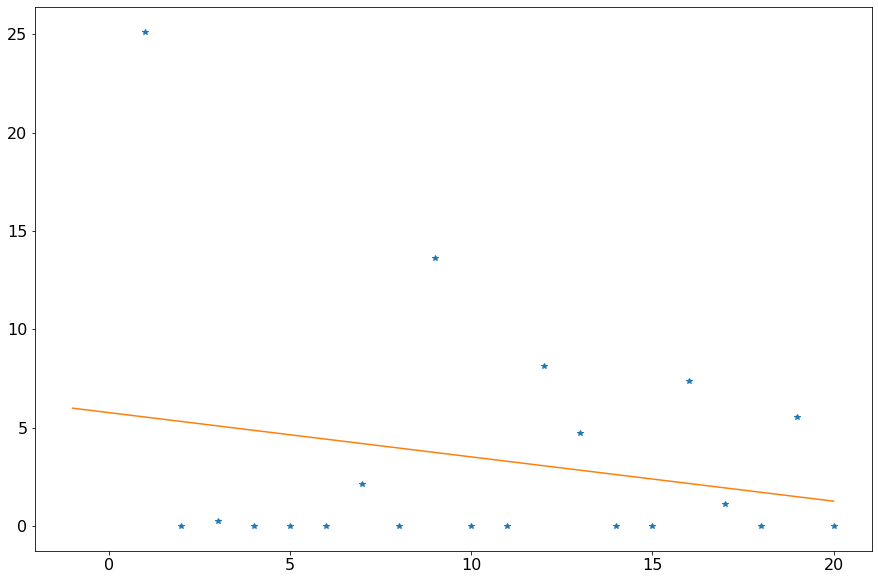

In [ ]:
stato="011"
k=26

x=np.zeros([points_fit])
y=np.zeros([points_fit])

for i in range(points_fit):
    if stato in new_res.get_counts(i*27+k):
        x[i]=(new_res.get_counts(i*27+k)[stato])
    y[i]=i+1

z=np.polyfit(y, x, 1)
print(z)

x_ = np.arange(-1, points_fit+1)
y_ = z[1]+z[0]*x_

plt.plot(y,x,marker="*",linestyle="")
plt.plot(x_,y_)
#plt.plot([0,0],[23000,31000],color="gray")

plt.show()

In [ ]:
qcs_aus = f2.evolution_tomo(type=evo_type, N_steps=steps, tempo=time, precision=precision, initial_state='110', check=[])

new_job = execute(qcs_aus, backend=backend_sim, shots=32000)
raw_results=new_job.result()
new_result = deepcopy(raw_results)

x=np.zeros(points_fit)
y=np.zeros(points_fit)




for j in range(27):

    new_counts={}

    for stato in f2.bin_list(3):
        for i in range(points_fit):
            if stato in new_res_our.get_counts(i*27+j):
                y[i]=new_res_our.get_counts(i*27+j)[stato]
            else:
                y[i]=0
            x[i]=i+1

        z=np.polyfit(x, y, 1)
        if z[1]>0:
            new_counts[stato]=z[1]
        else:
            new_counts[stato]=0
    
    new_result.results[j].data.counts = new_counts


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [ ]:
new_res.get_counts(26)

{'000': 1.5417956585905615e-10,
 '001': 1.837964380054327e-09,
 '010': 273.64444406699585,
 '011': 0.3301204532440959,
 '100': 2.8869082613568296e-13,
 '101': 4.073340246734405,
 '110': 8867.726900859863,
 '111': 25.118018397343082}

In [ ]:
new_res_our.get_counts(26)

{'000': 4.2928209876621957e-10,
 '001': 1.7325357608456084e-09,
 '010': 256.6187872350803,
 '011': 1.004027097917818e-08,
 '100': 1.2704497919324817e-09,
 '101': 1.1474235414367045e-08,
 '110': 9108.725731549659,
 '111': 1.0395812146920037e-08}

In [ ]:
target_state = (One^One^Zero).to_matrix()
fid=f2.fidelity_count(new_result, qcs_1_na, target_state)
fid

0.9749950476828012

In [ ]:
target_state = (One^One^Zero).to_matrix()
fid=f2.fidelity_count(new_res_our, qcs_1_na, target_state)
fid

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/result/result.py:395: UserWarning: Result object contained multiple results matching name "('X', 'X', 'X')", only first match will be returned. Use an integer index to retrieve results for all entries.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/result/result.py:395: UserWarning: Result object contained multiple results matching name "('X', 'X', 'Y')", only first match will be returned. Use an integer index to retrieve results for all entries.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/result/result.py:395: UserWarning: Result object contained multiple results matching name "('X', 'X', 'Z')", only first match will be returned. Use an integer index to retrieve results for all entries.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qi

0.973125378731604